# **BASE DE DATOS ECG**
## Tesista: Moises Meza-Rodriguez
### TEMA: Generación de señales sintéticas de Bloqueo de rama izquierda y derecha de la base de datos **ECG signals (1000 fragments)**

---

## **1.Entendimiento del negocio**



### **Problemática**
Muchos de los proyectos de clasificación que usan datasets sobre señales biomédicas, trabajan los modelos sin analizar la calidad de los datos lo cual sesga el resultado de salida. Parte de la calidad de los datos es verificar que las señales esten balanceadas y que cuenten con caracteristicas relevantes a su etiqueta. Sin embargo, es poco probable encontrar dataset cuyas clases esten balanceadas.

### **Justificación**
Proponemos desarrollar un modelo basados en redes GANs para generar sintéticamente señales de electrocardiograma, a partir de la base de datos de MIT-BIH. Nos centraremos en balancear las clases de bloqueo de rama izquierda(LBBBB) de 103 señales, bloqueo de rama derecha(LBBBB) de 62 señales, respecto a la señal ritmo sinusal normal(NSR) de 283 señales.

### **Sobre la base de datos**
Para fines de investigación, las señales de ECG se obtuvieron del servicio PhysioNet (http://www.physionet.org) de la base de datos de arritmias del MIT-BIH. La base de datos creada con señales de ECG se describe a continuación. 1) Las señales de ECG fueron de 45 pacientes: 19 mujeres (edad: 23-89) y 26 hombres (edad: 32-89). 2) Las señales de ECG contenían 17 clases: ritmo sinusal normal, ritmo de marcapasos y 15 tipos de disfunciones cardíacas (para cada una de las cuales se recogieron al menos 10 fragmentos de señal). 3) Todas las señales de ECG se registraron a una frecuencia de muestreo de 360 ​​[Hz] y una ganancia de 200 [adu / mV]. 4) Para el análisis, se seleccionaron aleatoriamente 1000 fragmentos de 10 segundos (3600 muestras) de la señal de ECG (no superpuestos). 5) Solo se utilizaron señales derivadas de una derivación, la MLII. 6) Los datos están en formato mat (Matlab).

## **2.Entendimiento de la data**

#### **Descarga de la data**

In [29]:
!wget https://data.mendeley.com/public-files/datasets/7dybx7wyfn/files/854dd691-aad3-4793-af3b-6142d1ec8a2a/file_downloaded -O dataset_ecg.zip

--2025-10-10 00:47:27--  https://data.mendeley.com/public-files/datasets/7dybx7wyfn/files/854dd691-aad3-4793-af3b-6142d1ec8a2a/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/503a174a-a723-4aaa-86f2-9483e7412a77 [following]
--2025-10-10 00:47:28--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/503a174a-a723-4aaa-86f2-9483e7412a77
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.92.18.98, 52.218.26.112, 3.5.72.105, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.92.18.98|:443...

In [30]:
!unzip dataset_ecg.zip -d ./dataset_ecg

Archive:  dataset_ecg.zip
replace ./dataset_ecg/MLII/1 NSR/100m (0).mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### **Acceso a la data**

In [31]:
path = "dataset_ecg/MLII/"

In [32]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

Lista de las rutas de NSR, LBBBB y RBBBB

In [33]:
list_NSR = glob.glob(path+"? NSR*/*.mat", recursive=True)
list_LBBBB = glob.glob(path+"?? LBBBB*/*.mat", recursive=True)
list_RBBBB = glob.glob(path+"?? RBBBB*/*.mat", recursive=True)

#### **Graficamos una señal de ejemplo de cada lista**

Leemos el contenido de las señales usando scipy

In [34]:
from scipy.io import loadmat

data_test = loadmat(list_NSR[0])
data_test

{'val': array([[836, 836, 834, ..., 807, 807, 808]], dtype=int16)}

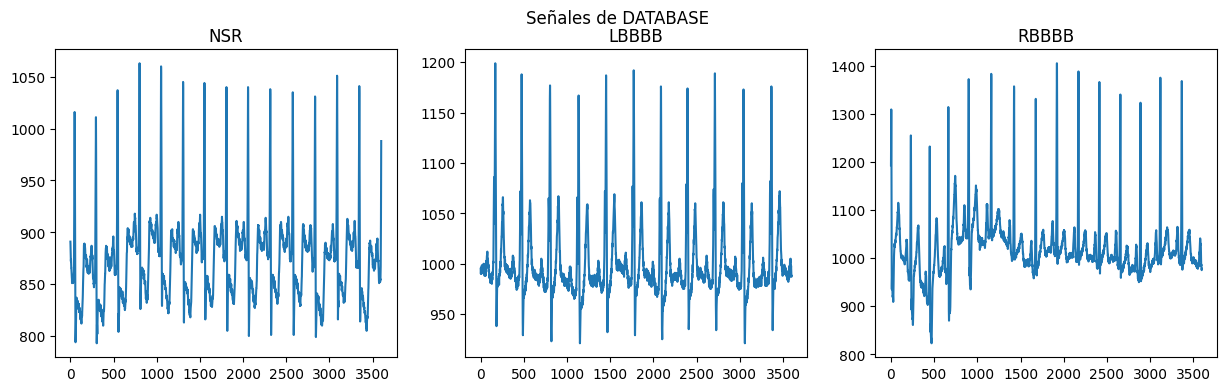

In [35]:
pos = 10

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.suptitle("Señales de DATABASE\n")
plt.plot(loadmat(list_NSR[pos])["val"][0])
plt.title("NSR")
plt.subplot(1,3,2)
plt.plot(loadmat(list_LBBBB[pos])["val"][0])
plt.title("LBBBB")
plt.subplot(1,3,3)
plt.plot(loadmat(list_RBBBB[pos])["val"][0])
plt.title("RBBBB")
plt.show()

Diagrama de barras de cantidad de señales por clase

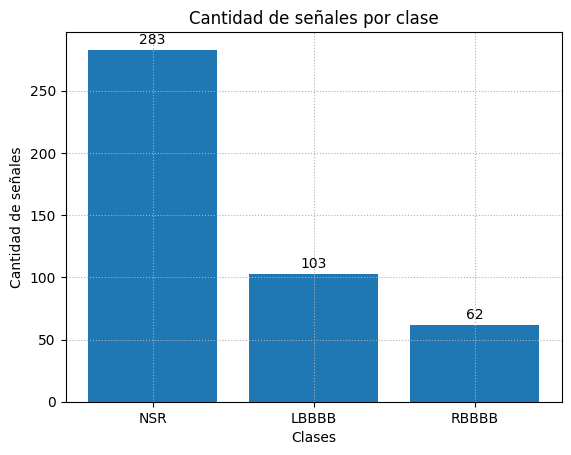

In [36]:
len_NSR = len(list_NSR)
len_LBBBB = len(list_LBBBB)
len_RBBBB = len(list_RBBBB)

labels = ["NSR", "LBBBB", "RBBBB"]
values = [len_NSR, len_LBBBB, len_RBBBB]

plt.bar(labels, values)
plt.xlabel("Clases")
plt.ylabel("Cantidad de señales")
plt.title("Cantidad de señales por clase")
plt.grid(ls=":")

# Add the counts on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 5, str(value), ha='center') # Added text labels on top of bars

plt.show()

#### **EDA de las señales LBBBB , RBBBB y NSR**

Number of NSR samples: 283
Number of LBBBB samples: 103
Number of RBBBB samples: 62


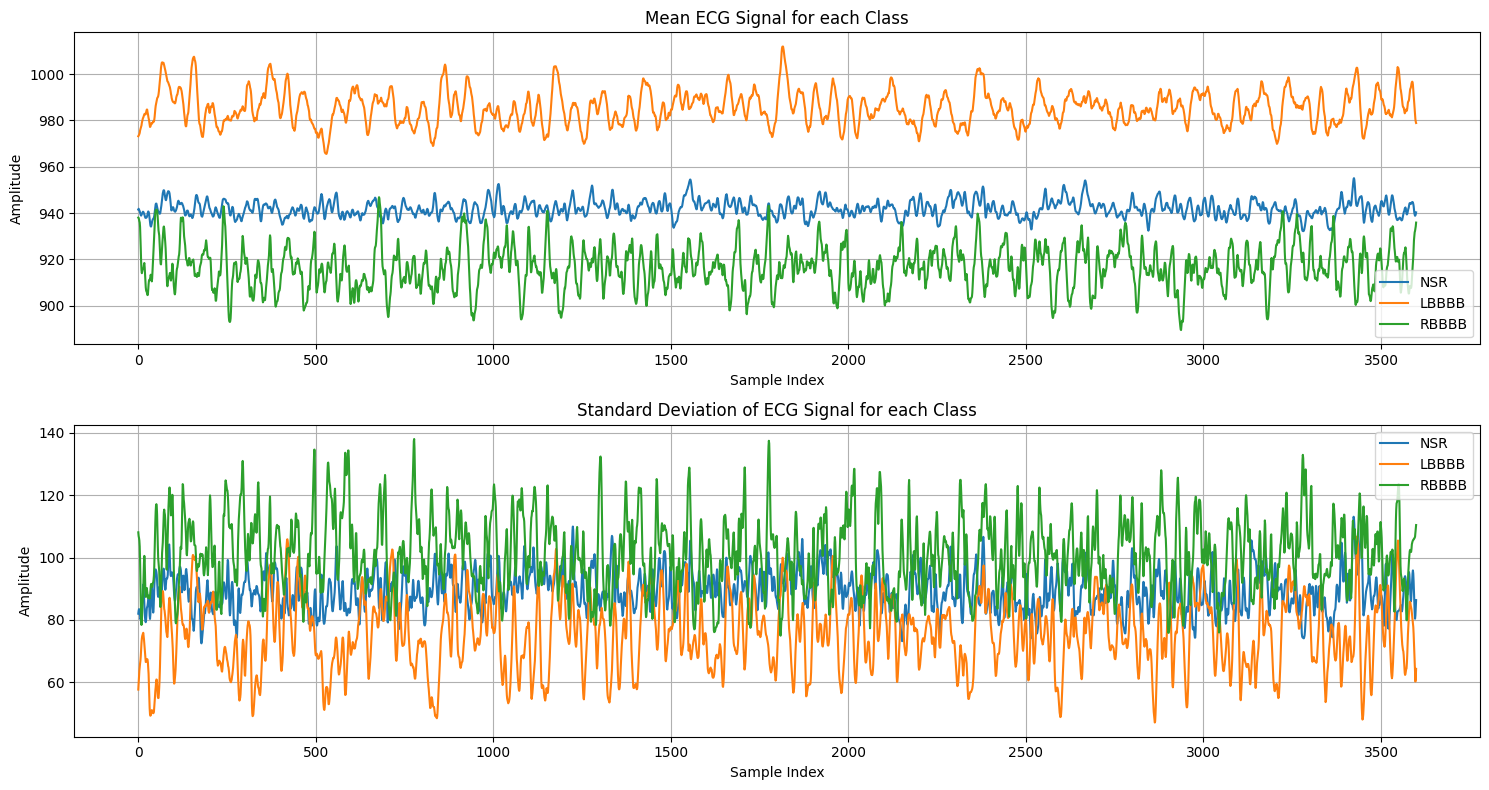

In [37]:
# Function to load and combine data from a list of .mat files
def load_ecg_data(file_list):
    data = []
    for file in file_list:
        mat_data = loadmat(file)
        data.append(mat_data['val'][0])
    return np.array(data)

# Load the data for each class
data_NSR = load_ecg_data(list_NSR)
data_LBBBB = load_ecg_data(list_LBBBB)
data_RBBBB = load_ecg_data(list_RBBBB)

# Get the number of samples for each class
num_NSR = len(data_NSR)
num_LBBBB = len(data_LBBBB)
num_RBBBB = len(data_RBBBB)

print(f"Number of NSR samples: {num_NSR}")
print(f"Number of LBBBB samples: {num_LBBBB}")
print(f"Number of RBBBB samples: {num_RBBBB}")

# Calculate basic statistics (mean and standard deviation) for each class
mean_NSR = np.mean(data_NSR, axis=0)
std_NSR = np.std(data_NSR, axis=0)

mean_LBBBB = np.mean(data_LBBBB, axis=0)
std_LBBBB = np.std(data_LBBBB, axis=0)

mean_RBBBB = np.mean(data_RBBBB, axis=0)
std_RBBBB = np.std(data_RBBBB, axis=0)

# Plot the mean and standard deviation of the signals for each class
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(mean_NSR, label='NSR')
plt.plot(mean_LBBBB, label='LBBBB')
plt.plot(mean_RBBBB, label='RBBBB')
plt.title('Mean ECG Signal for each Class')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(std_NSR, label='NSR')
plt.plot(std_LBBBB, label='LBBBB')
plt.plot(std_RBBBB, label='RBBBB')
plt.title('Standard Deviation of ECG Signal for each Class')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### **Extracción de caracteristicas estadísticas**

In [38]:
# Function to extract features from a single ECG signal
def extract_features(signal):
    features = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'median': np.median(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'ptp': np.ptp(signal), # Peak-to-peak amplitude
        'variance': np.var(signal),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    }
    return features

# Extract features for each class
features_NSR = pd.DataFrame([extract_features(signal) for signal in data_NSR])
features_LBBBB = pd.DataFrame([extract_features(signal) for signal in data_LBBBB])
features_RBBBB = pd.DataFrame([extract_features(signal) for signal in data_RBBBB])

# Add a 'class' column to each DataFrame
features_NSR['class'] = 'NSR'
features_LBBBB['class'] = 'LBBBB'
features_RBBBB['class'] = 'RBBBB'

# Combine the feature DataFrames
all_features = pd.concat([features_NSR, features_LBBBB, features_RBBBB])

# Display the DataFrame containing features for all signals
display(all_features)

,mean,std,median,min,max,ptp,variance,skewness,kurtosis,class
0,865.478056,41.103894,858.0,801,1082,281,1689.530074,2.697680,9.221513,NSR
1,863.555556,40.173419,855.0,812,1066,254,1613.903580,2.796860,9.146752,NSR
2,980.348611,41.657224,972.0,926,1319,393,1735.324304,3.888978,20.476193,NSR
3,969.182778,39.393533,962.0,913,1277,364,1551.850481,3.775063,20.998998,NSR
4,974.783056,58.017137,957.0,904,1349,445,3365.988213,2.609335,9.175461,NSR
...,...,...,...,...,...,...,...,...,...,...
57,1002.757500,63.696444,994.0,857,1327,470,4057.237027,1.316790,4.427046,RBBBB
58,842.581944,71.996037,829.0,746,1292,546,5183.429396,3.545274,15.497694,RBBBB
59,968.408333,64.506907,963.0,814,1278,464,4161.141042,1.128217,3.543319,RBBBB
60,868.018333,79.136662,879.0,588,1173,585,6262.611331,-0.812469,4.634228,RBBBB


In [39]:
all_features

,mean,std,median,min,max,ptp,variance,skewness,kurtosis,class
0,865.478056,41.103894,858.0,801,1082,281,1689.530074,2.697680,9.221513,NSR
1,863.555556,40.173419,855.0,812,1066,254,1613.903580,2.796860,9.146752,NSR
2,980.348611,41.657224,972.0,926,1319,393,1735.324304,3.888978,20.476193,NSR
3,969.182778,39.393533,962.0,913,1277,364,1551.850481,3.775063,20.998998,NSR
4,974.783056,58.017137,957.0,904,1349,445,3365.988213,2.609335,9.175461,NSR
...,...,...,...,...,...,...,...,...,...,...
57,1002.757500,63.696444,994.0,857,1327,470,4057.237027,1.316790,4.427046,RBBBB
58,842.581944,71.996037,829.0,746,1292,546,5183.429396,3.545274,15.497694,RBBBB
59,968.408333,64.506907,963.0,814,1278,464,4161.141042,1.128217,3.543319,RBBBB
60,868.018333,79.136662,879.0,588,1173,585,6262.611331,-0.812469,4.634228,RBBBB


In [42]:
all_features.to_csv("all_features_csv.csv", index=False)

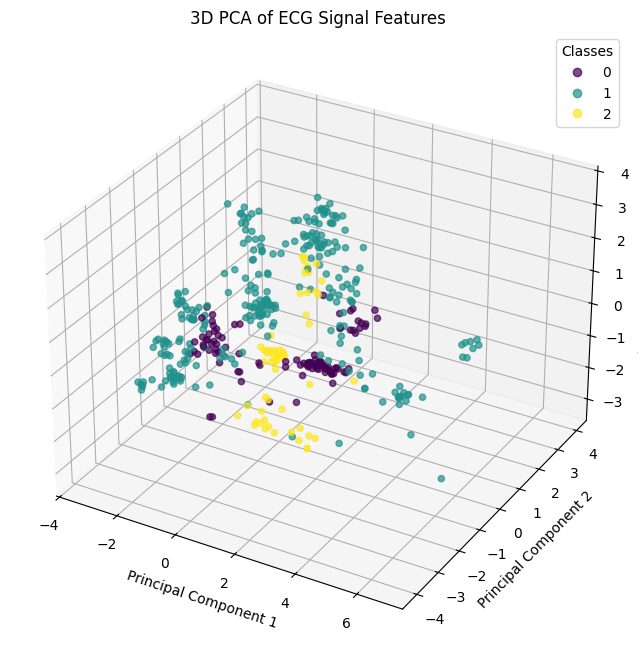

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting

# Separate features and labels from the all_features DataFrame
X = all_features.drop('class', axis=1)
y = all_features['class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA with 3 components
pca = PCA(n_components=3)

# Fit PCA on the scaled features and transform the data
X_pca = pca.fit_transform(X_scaled)

# Create a 3D scatter plot of the PCA results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') # Create a 3D subplot

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y.astype('category').cat.codes, cmap='viridis', alpha=0.7)

# Add labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of ECG Signal Features')

# Add a legend
legend = ax.legend(*scatter.legend_elements(), title="Classes")

plt.show()

#### Prueba de modelos

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Define features (X) and target (y)
X = all_features.drop('class', axis=1)
y = all_features['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

# Initialize different classifiers
classifiers = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "Gaussian Process": GaussianProcessClassifier(random_state=42)
}

# Train each classifier
trained_models = {}
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train_scaled, y_train)
    trained_models[name] = clf
    print(f"{name} trained.")

# Evaluate models
results = {}
for name, clf in trained_models.items():
    y_pred = clf.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    # Use zero_division=0 to handle cases where there are no predicted samples for a class
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Classification Report": classification_report(y_test, y_pred, zero_division=0),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Print the evaluation metrics for each model
for name, metrics in results.items():
    print(f"--- {name} ---")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print("\nClassification Report:")
    print(metrics['Classification Report'])
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("-" * (len(name) + 6))

Training set shape: (313, 9)
Testing set shape: (135, 9)
Training K-Nearest Neighbors...
K-Nearest Neighbors trained.
Training Random Forest...
Random Forest trained.
Training Support Vector Machine...
Support Vector Machine trained.
Training Logistic Regression...
Logistic Regression trained.
Training Decision Tree...
Decision Tree trained.
Training Gaussian Naive Bayes...
Gaussian Naive Bayes trained.
Training Linear Discriminant Analysis...
Linear Discriminant Analysis trained.
Training Quadratic Discriminant Analysis...
Quadratic Discriminant Analysis trained.
Training Gaussian Process...
Gaussian Process trained.


/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


--- K-Nearest Neighbors ---
Accuracy: 0.9259
Precision: 0.9279
Recall: 0.9259
F1 Score: 0.9266

Classification Report:
              precision    recall  f1-score   support

       LBBBB       0.82      0.87      0.84        31
         NSR       0.95      0.93      0.94        85
       RBBBB       1.00      1.00      1.00        19

    accuracy                           0.93       135
   macro avg       0.92      0.93      0.93       135
weighted avg       0.93      0.93      0.93       135

Confusion Matrix:
[[27  4  0]
 [ 6 79  0]
 [ 0  0 19]]
-------------------------
--- Random Forest ---
Accuracy: 0.9630
Precision: 0.9650
Recall: 0.9630
F1 Score: 0.9619

Classification Report:
              precision    recall  f1-score   support

       LBBBB       1.00      0.84      0.91        31
         NSR       0.94      1.00      0.97        85
       RBBBB       1.00      1.00      1.00        19

    accuracy                           0.96       135
   macro avg       0.98      0.95 